In [17]:
## ORIGINAL LOADING CODE, NOt import anymore I think - Gabby

import os
import json
from collections import defaultdict

# Path to the directory you want to search
directory_path = './'

# This will hold the count of unique combinations
combinations = defaultdict(int)
combination_set = set()
# Loop through each folder, subfolder, and file
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if the file is a JSON file
        if file.endswith('.json'):
            json_path = os.path.join(root, file)
            # Open and read the JSON file
            with open(json_path, 'r') as json_file:
                data = json.load(json_file)
                # Extract the lesion and asymmetry values
                lesion_class = data.get("Lesion Class")
                asymmetry_label = data.get("Asymmetry Label")
                if lesion_class and asymmetry_label:
                    # Increment the count for this combination
                    combination_set.add((lesion_class, asymmetry_label))
                    combinations[(lesion_class, asymmetry_label)] += 1


# Now combinations dictionary has all unique combinations and their counts
total_combinations = len(combinations)
print(f'Total unique combinations of lesion and asymmetry: {total_combinations}')
print(combination_set)
# If you want to see the combinations,


Total unique combinations of lesion and asymmetry: 8
{('Atypical Nevus', 'Fully Symmetric'), ('Common Nevus', 'Fully Symmetric'), ('Common Nevus', 'Fully Asymmetric'), ('Atypical Nevus', 'Symmetric in 1 axes'), ('Common Nevus', 'Symmetric in 1 axes'), ('Melanoma', 'Fully Symmetric'), ('Melanoma', 'Fully Asymmetric'), ('Atypical Nevus', 'Fully Asymmetric')}


### Skin Lesion Segmentation Project
Team 7 Members (Undergraduate): Samhith Bhrugubanda, Gabby Kang, William Li, Sampath Rampuri

#### Section 1: Pre processing and Loading data

In [18]:
# Import relavant packages
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

In [19]:
"ABC" == "ABC"

True

In [20]:
# Load data
images = list()         # List of color images
masks = list()          # List of ground truth mask segmentations of the skin lesions
labels = list()         # List of classifications, each entry is a 2x1 vector of [lesion_class, assymmetry]
asymmetry_labels = list()
# Loop through each folder, subfolder, and file
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if the file is a JSON file
        if file.endswith('.json'):
            json_path = os.path.join(root, file)
            # Open and read the JSON file
            with open(json_path, 'r') as json_file:
                data = json.load(json_file)
                # Extract asymmetry values
                asymmetry_label = data.get("Asymmetry Label")
                if (asymmetry_label != None):
                    if (asymmetry_label == "Fully Symmetric"): asymmetry_label = [1, 0, 0]
                    elif (asymmetry_label == "Symmetric in 1 axes"): asymmetry_label = [0, 1, 0]
                    elif (asymmetry_label == "Fully Asymmetric"): asymmetry_label = [0, 0, 1]
                    else: print(json_path, asymmetry_label)
                    asymmetry_labels.append(asymmetry_label)
                    # Extract lesion classification
                    lesion_class = data.get("Lesion Class")
                    if (lesion_class == "Common Nevus"): lesion_class = [1, 0, 0]
                    elif (lesion_class == "Atypical Nevus"): lesion_class = [0, 1, 0]
                    elif (lesion_class == "Melanoma"): lesion_class = [0, 0, 1]
                    labels.append([lesion_class])
        # Check if the file is a JSON file
        elif file.endswith('.bmp'):
            im_path = os.path.join(root, file)
            if (file.__contains__("lesion")):
                masks.append(cv2.imread(im_path))
            else:
                images.append(cv2.imread(im_path))

#### Section 2: Segmentation
The following section contains helper functions for various morphological operators that are used to perform the segmentation. A sample process showing each morphological operation is shown separately, and all segmented images are stored in the list, mask_hat.

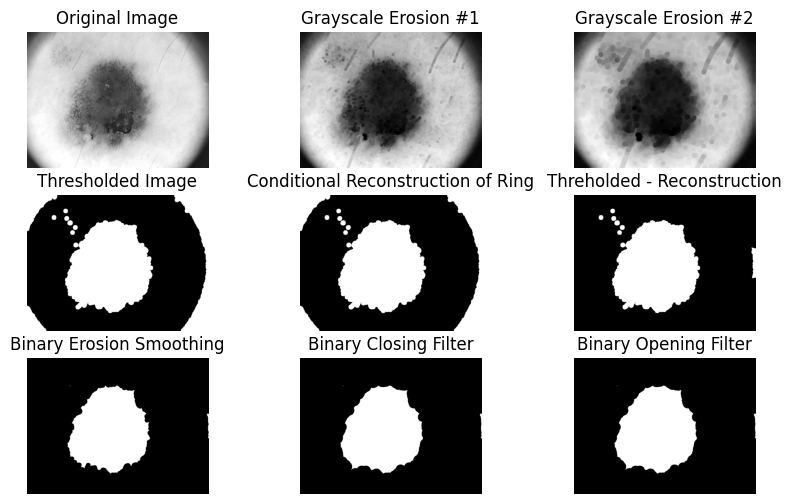

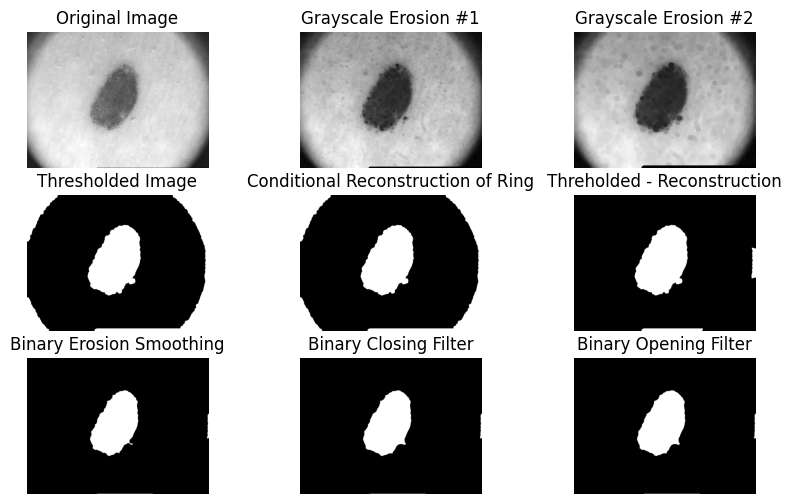

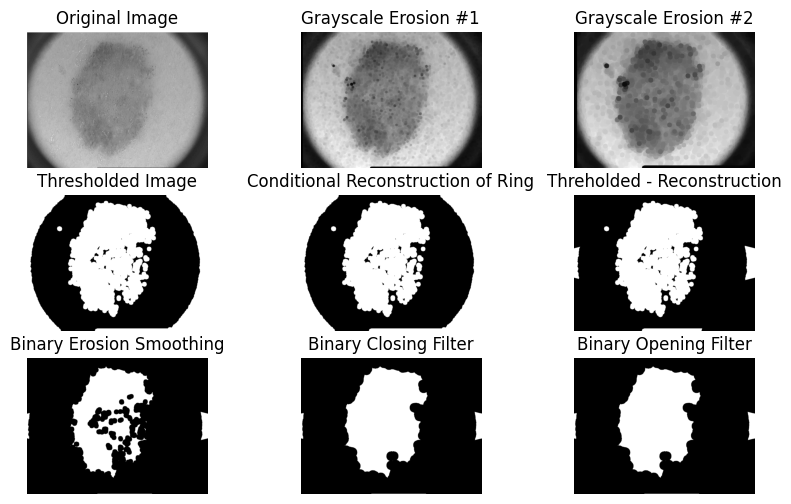

In [21]:
def generate_discrete_disk(radius):
    diameter = 2 * radius + 1 
    center = radius 

    # Generate a grid of coordinates
    x, y = np.meshgrid(np.arange(diameter), np.arange(diameter))

    # Calculate the distance from each point to the center
    distances = np.sqrt((x - center)**2 + (y - center)**2)

    # Create a mask for the disk
    disk_mask = (distances <= radius).astype(np.uint8)

    return disk_mask
def conditional_reconstruction(im, marker, b, num_iter = 10):
    for i in range(num_iter):
        temp = cv2.dilate(marker, b)
        marker = cv2.bitwise_and(im.astype(np.uint8), temp.astype(np.uint8))
    return marker
def plot_and_title(im, subplot_id, title):
    plt.subplot(subplot_id)
    plt.imshow(im, cmap = "gray")
    plt.title(title)
    plt.axis('off')  
def mask_segmentation(im, disp = False):
    # Initialize structural elements
    disk = generate_discrete_disk(5)
    big_disk = generate_discrete_disk(10)

    mask_steps = list()                             # List of intermediary steps, used for display purposes only
    mask = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)     # Initialize mask.
    mask_steps.append(mask)
    # Step 0: Gamma contrast enhance image
    mask = np.power(mask, 1.5).astype(np.uint16)
    # Step 1: Use repeated grayscale erosion to smooth out color variation
    mask = cv2.erode(mask, disk)
    mask_steps.append(mask)
    mask = cv2.erode(mask, disk)
    mask_steps.append(mask)

    # Step 2: Perform an initial thresholding operation in order to generate a binary approximation
    _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
    mask_steps.append(mask)

    # Step 3: Perform conditional reconstruction using the edge as a marker to get rid of ring edge artifact
    edge_marker = np.zeros(mask.shape)
    edge_marker[0, 0] = 1
    edge_marker[-1, 0] = 1
    edge_marker[0, -1] = 1
    edge_marker[-1,-1] = 1
    recon = conditional_reconstruction(mask, edge_marker, big_disk, num_iter = 20)
    recon = conditional_reconstruction(mask, recon, disk, num_iter=5)
    mask_steps.append(mask) 

    # Step 4: Remove edge artifact by subtracting the conditional reconstruction from the original mask
    mask = mask == cv2.bitwise_not(recon.astype(np.uint8))
    mask_steps.append(mask)

    # Step 5: Smooth the binary mask with an erosion. This has the added benefit of reducing the size of
    #         segmented regions, making small artificial regions easy to filter out in the later steps
    mask = cv2.morphologyEx(mask.astype(np.uint16), cv2.MORPH_ERODE, big_disk)
    mask_steps.append(mask)
    
    # Step 6: Smooth the binary mask with a dilation to restore some of the original size
    # mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_DILATE, disk)
    # mask_steps.append(mask)

    # Step 7: Filter out small foreground shapes with a binary closing.
    mask = cv2.morphologyEx(mask.astype(np.uint16), cv2.MORPH_CLOSE,  generate_discrete_disk(20))
    mask_steps.append(mask)

    # Step 8: Now fill holes with a binary opening. Use a rectangular structural element. This acts like a bar
    #         to quickly flood background
    mask = cv2.morphologyEx(mask.astype(np.uint16), cv2.MORPH_CLOSE, np.ones([5, 70]))
    mask_steps.append(mask)
    # Plot each intermediary step
    if (disp == True):
        plt.figure(figsize=(10, 6)) 
        plot_and_title(mask_steps[0], 331, "Original Image")
        plot_and_title(mask_steps[1], 332, "Grayscale Erosion #1")
        plot_and_title(mask_steps[2], 333, "Grayscale Erosion #2")
        plot_and_title(mask_steps[3], 334, "Thresholded Image")
        plot_and_title(mask_steps[4], 335, "Conditional Reconstruction of Ring")
        plot_and_title(mask_steps[5], 336, "Threholded - Reconstruction")
        plot_and_title(mask_steps[6], 337, "Binary Erosion Smoothing")
        plot_and_title(mask_steps[7], 338, "Binary Closing Filter")
        plot_and_title(mask_steps[7], 339, "Binary Opening Filter")
    return mask

mask = mask_segmentation(images[121], disp = True)
mask = mask_segmentation(images[100], disp = True)
mask = mask_segmentation(images[4], disp = True)


In [22]:
## Now, evaluate IoU and DICE scores
def calc_dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    total = mask1.sum() + mask2.sum() 
    dice = 2 * intersection / total if total > 0 else 1
    return dice

def calc_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = intersection / union if union > 0 else 1
    return iou

mask_hat = list()
iou = list()
dice = list()
temp_groundtruth = list()
for image_id in range(150):
    mask_hat.append(mask_segmentation(images[image_id], disp = False))
    ground_truth = cv2.cvtColor(masks[image_id], cv2.COLOR_BGR2GRAY) > 0
    temp_groundtruth.append(ground_truth)
    dice.append(calc_dice(mask_hat[image_id], ground_truth))  
    iou.append(calc_iou(mask_hat[image_id], ground_truth)) 

    # Print
    if image_id % 25 == 0:
        print("Working on image ", image_id)

Working on image  0
Working on image  25
Working on image  50
Working on image  75
Working on image  100
Working on image  125


Text(0.5, 1.0, 'Histogram of DICE Scores')

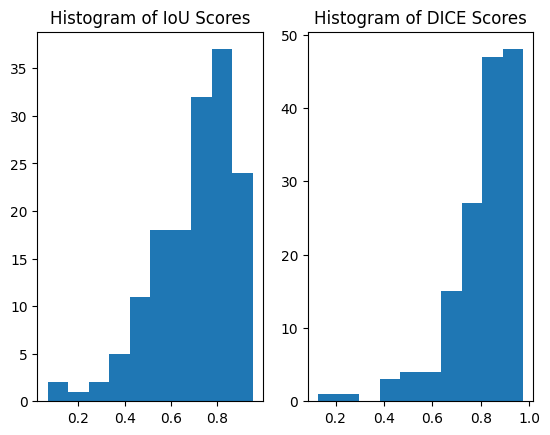

In [23]:
plt.figure()
plt.subplot(121)
plt.hist(iou)
plt.title("Histogram of IoU Scores")
plt.subplot(122)
plt.hist(dice)
plt.title("Histogram of DICE Scores")

0.8580166763136899 0.7513390594391705
0.9384977520945125 0.8841222465108458


Text(0.5, 1.0, 'ground truth')

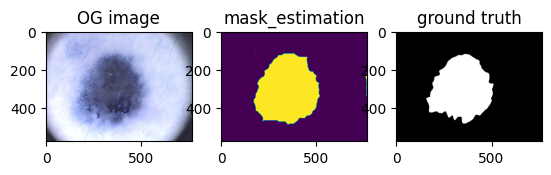

In [24]:
print(dice[4], iou[4])
print(dice[121], iou[121])
mask = mask_segmentation(images[121], disp = False)
plt.figure()
plt.subplot(131)
plt.imshow(images[121])
plt.title("OG image")

plt.subplot(132)
plt.imshow(mask)
plt.title("mask_estimation")

plt.subplot(133)
plt.imshow(masks[121])
plt.title("ground truth")

### Classification

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

In [26]:
from torchsummary import summary

In [27]:
class NetworkModel(nn.Module):
    def __init__(self, feature_input_size, num_classes, pretrained=True):
        super(NetworkModel, self).__init__()

        # Load pre-trained backbone model
        backbone_model = models.resnet18(pretrained=pretrained)
        self.features_size = backbone_model.fc.in_features
        self.backbone = nn.Sequential(*list(backbone_model.children())[:-1])
        # Define additional layers for processing the combined input
        self.fc_layers = nn.Sequential(
            nn.Linear(self.features_size + feature_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.Sigmoid()
        )

    def forward(self, image_input, feature_input):
        # Pass image input through the backbone model
        image_features = self.backbone(image_input)
        image_features = torch.flatten(image_features, 1)
        # olor_features = self.backbone(color_input)
        # color_features = torch.flatten(color_features, 1)
        # Concatenate image features with additional feature input
        combined_input = torch.cat((image_features, feature_input), dim=1)

        # Pass combined input through FC layers
        output = self.fc_layers(combined_input)
        return output


In [28]:
print(len(images))
print(len(temp_groundtruth))
print(len(asymmetry_labels))
print(len(labels))

150
150
150
150


In [29]:
batchsize = 32
image_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize the image to 300x300
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),           # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229])  # Normalize image
])
rgb_images = [np.transpose(np.stack((im,) * 3, axis=-1), [2, 0, 1]) for im in temp_groundtruth]
dataset = TensorDataset(torch.stack([image_transform(Image.fromarray(im)) for im in temp_groundtruth]), 
                # torch.stack([image_transform(Image.fromarray(im)) for im in images]), 
                torch.tensor(asymmetry_labels), torch.tensor(labels))
dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)


In [30]:
def train(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    loss_list = list()
    for epoch in range(epochs):
        running_loss = 0.0
        # for mask, color_images, asymmetry, labels in train_loader:
        #     mask, color_images, asymmetry, labels = mask.to(device), color_images.to(device), asymmetry.to(device), labels.to(device)
        for mask, asymmetry, labels in train_loader:
            mask, asymmetry, labels = mask.to(device), asymmetry.to(device), labels.to(device)
            optimizer.zero_grad()
        #     outputs = model(mask, color_images, asymmetry)
            outputs = model(mask, asymmetry)
            #print(outputs)
            loss = criterion(outputs.to(torch.float), labels.squeeze(1).to(torch.float))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss/len(train_loader))
        print("Epoch: ", str(epoch + 1), "/", str(epochs), ", Loss: " + str(running_loss/len(train_loader)))
    return model, loss_list
model = NetworkModel(3, 3)

# Example usage of optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Change this according to your task


In [31]:
def acc_validation (prediction, actual_labels, thresh=0.9):
    acc_list = list()
    for batch in range(len(actual_labels)):
        for label in range(prediction[batch].shape[0]):
            pre = prediction[batch][label, :].detach().numpy()
            real = actual_labels[batch][label, :].detach().numpy()
            # find the max value in the prediction:
            class_thresh = pre[np.argmax(pre)]
            # Convert predicted label into 1 hot encoded with class_thresh
            pre = pre >= class_thresh
            # Compute average similarity, and append
            acc_list.append(np.sum(pre == real))
    return acc_list

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
overall_loss = list()
# Train for 10 full iterations, each 10 epochs
for i in range(10):
    print("Iteration ", i)
    # Train the model
    [model, loss_list] = train(model, dataloader, optimizer, criterion, epochs=10)
    overall_loss.extend(loss_list)
    model.eval()
    prediction = list()
    actual_labels = list()
    # for mask, color, asymmetry, gt_labels in dataloader:
    #     prediction.append(model(mask, color, asymmetry))
    #     actual_labels.append(gt_labels)
    for mask, asymmetry, gt_labels in dataloader:
        prediction.append(model(mask, asymmetry))
        actual_labels.append(gt_labels)
    val_acc = (acc_validation(prediction, actual_labels, thresh=0.9))
    torch.save(model.state_dict(), 'masks_and_asymmetry.pth')
    print("Correct predictions: " , np.sum(np.array(val_acc)== 3))
plt.plot(overall_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")


Iteration  0
Epoch:  1 / 10 , Loss: 1.0921688795089721
Epoch:  2 / 10 , Loss: 1.0406185865402222
Epoch:  3 / 10 , Loss: 0.9672626376152038
Epoch:  4 / 10 , Loss: 0.9029646754264832
Epoch:  5 / 10 , Loss: 0.8331696271896363
Epoch:  6 / 10 , Loss: 0.7765612959861755
Epoch:  7 / 10 , Loss: 0.758382773399353
Epoch:  8 / 10 , Loss: 0.7090194940567016
Epoch:  9 / 10 , Loss: 0.6702179312705994
Epoch:  10 / 10 , Loss: 0.7293920993804932
Correct predictions:  96
Iteration  1
Epoch:  1 / 10 , Loss: 0.7112000107765197
Epoch:  2 / 10 , Loss: 0.6970962882041931
Epoch:  3 / 10 , Loss: 0.6636632204055786
Epoch:  4 / 10 , Loss: 0.6507669448852539
Epoch:  5 / 10 , Loss: 0.637097156047821
Epoch:  6 / 10 , Loss: 0.607272458076477
Epoch:  7 / 10 , Loss: 0.6161490321159363
Epoch:  8 / 10 , Loss: 0.6087439060211182
Epoch:  9 / 10 , Loss: 0.5998570442199707
Epoch:  10 / 10 , Loss: 0.626804530620575
Correct predictions:  136
Iteration  2
Epoch:  1 / 10 , Loss: 0.6139340043067932


KeyboardInterrupt: 

In [ ]:
print(overall_loss)
print(prediction[0].unsqueeze(1).shape)
print(actual_labels[0].squeeze(1).shape)
print(criterion(prediction[0].to(torch.float), actual_labels[0].squeeze(1).to(torch.float)))

[[1.0810606002807617, 1.0088657975196837]]
torch.Size([32, 1, 3])
torch.Size([32, 3])
tensor(0.9529, grad_fn=<DivBackward1>)


: 